# Loop 20 LB Feedback Analysis

**LB Score: 70.6304** (CV = LB exactly - deterministic problem)

## Key Observations:
1. After 21 experiments, all SA-based approaches converge to ~70.630
2. Last 11 experiments yielded only 0.000085 total improvement
3. Gap to target: 1.711 points (2.42%)
4. Need fundamentally different approach

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely.affinity import rotate, translate
import matplotlib.pyplot as plt

# Tree template
TREE_TEMPLATE = [
    (0.0, 0.8), (0.125, 0.5), (0.0625, 0.5), (0.2, 0.25), (0.1, 0.25),
    (0.35, 0.0), (0.075, 0.0), (0.075, -0.2), (-0.075, -0.2), (-0.075, 0.0),
    (-0.35, 0.0), (-0.1, 0.25), (-0.2, 0.25), (-0.0625, 0.5), (-0.125, 0.5)
]

def parse_s_value(val):
    if isinstance(val, str):
        if val.startswith('s'):
            return float(val[1:])
        return float(val)
    return float(val)

def create_tree_polygon(x, y, angle):
    tree = Polygon(TREE_TEMPLATE)
    tree = rotate(tree, angle, origin=(0, 0), use_radians=False)
    tree = translate(tree, x, y)
    return tree

def get_bounding_box_side(trees):
    all_x = []
    all_y = []
    for tree in trees:
        minx, miny, maxx, maxy = tree.bounds
        all_x.extend([minx, maxx])
        all_y.extend([miny, maxy])
    return max(max(all_x) - min(all_x), max(all_y) - min(all_y))

# Load current best submission
df = pd.read_csv('/home/submission/submission.csv')
df['x'] = df['x'].apply(parse_s_value)
df['y'] = df['y'].apply(parse_s_value)
df['deg'] = df['deg'].apply(parse_s_value)
df['n'] = df['id'].apply(lambda x: int(x.split('_')[0]))

print(f"Loaded {len(df)} rows")
print(f"N range: {df['n'].min()} to {df['n'].max()}")
print(f"Unique N values: {df['n'].nunique()}")
print(df.head())

Loaded 20100 rows
N range: 1 to 200
Unique N values: 200
      id          x          y         deg  n
0  001_0 -48.196086  58.770985   45.000000  1
1  002_0   0.154097  -0.038541  203.629378  2
2  002_1  -0.154097  -0.561459   23.629378  2
3  003_0   1.123656   0.781102  111.125132  3
4  003_1   1.234056   1.276000   66.370622  3


In [2]:
# Calculate score breakdown by N
scores_by_n = {}
for n in range(1, 201):
    group = df[df['n'] == n]
    trees = [create_tree_polygon(row['x'], row['y'], row['deg']) for _, row in group.iterrows()]
    side = get_bounding_box_side(trees)
    scores_by_n[n] = {
        'side': side,
        'score': (side ** 2) / n,
        'efficiency': n / (side ** 2)  # trees per unit area
    }

total_score = sum(s['score'] for s in scores_by_n.values())
print(f"Total score: {total_score:.6f}")
print(f"Target: 68.919154")
print(f"Gap: {total_score - 68.919154:.6f}")

# Find worst N values (highest score contribution)
worst_n = sorted(scores_by_n.items(), key=lambda x: x[1]['score'], reverse=True)[:20]
print("\nWorst N values (highest score contribution):")
for n, data in worst_n:
    print(f"  N={n}: score={data['score']:.6f}, side={data['side']:.4f}, efficiency={data['efficiency']:.4f}")

Total score: 70.627896
Target: 68.919154
Gap: 1.708742

Worst N values (highest score contribution):
  N=1: score=0.661250, side=0.8132, efficiency=1.5123
  N=2: score=0.450779, side=0.9495, efficiency=2.2184
  N=3: score=0.434745, side=1.1420, efficiency=2.3002
  N=5: score=0.416850, side=1.4437, efficiency=2.3989
  N=4: score=0.416545, side=1.2908, efficiency=2.4007
  N=7: score=0.399897, side=1.6731, efficiency=2.5006
  N=6: score=0.399610, side=1.5484, efficiency=2.5024
  N=9: score=0.387415, side=1.8673, efficiency=2.5812
  N=8: score=0.385407, side=1.7559, efficiency=2.5947
  N=15: score=0.376978, side=2.3780, efficiency=2.6527
  N=10: score=0.376630, side=1.9407, efficiency=2.6551
  N=21: score=0.376451, side=2.8117, efficiency=2.6564
  N=20: score=0.376057, side=2.7425, efficiency=2.6592
  N=22: score=0.375258, side=2.8733, efficiency=2.6648
  N=11: score=0.374924, side=2.0308, efficiency=2.6672
  N=16: score=0.374128, side=2.4466, efficiency=2.6729
  N=26: score=0.373997, side

In [3]:
# Calculate theoretical lower bound
# The tree has a bounding box of approximately 0.7 x 1.0 = 0.7 area
# For perfect packing, efficiency would be tree_area / bbox_area

# Tree area (approximate from polygon)
tree_poly = Polygon(TREE_TEMPLATE)
tree_area = tree_poly.area
print(f"Tree area: {tree_area:.6f}")

# For N trees, theoretical minimum side S satisfies:
# N * tree_area <= S^2 (all trees fit in square)
# So S >= sqrt(N * tree_area)
# Score = S^2/N >= tree_area

theoretical_min_score_per_n = tree_area
print(f"Theoretical minimum score per N: {theoretical_min_score_per_n:.6f}")
print(f"Theoretical minimum total score: {200 * theoretical_min_score_per_n:.6f}")

# But this is unrealistic - trees can't pack perfectly
# Let's look at the best efficiency achieved
best_efficiency = max(s['efficiency'] for s in scores_by_n.values())
print(f"\nBest efficiency achieved: {best_efficiency:.6f} trees per unit area")
print(f"Corresponding minimum score per N: {1/best_efficiency:.6f}")

# Calculate what score we'd get if all N had best efficiency
if_all_best = sum(1/best_efficiency for _ in range(1, 201))
print(f"If all N had best efficiency: {if_all_best:.6f}")

Tree area: 0.245625
Theoretical minimum score per N: 0.245625
Theoretical minimum total score: 49.125000

Best efficiency achieved: 3.030811 trees per unit area
Corresponding minimum score per N: 0.329945
If all N had best efficiency: 65.988929


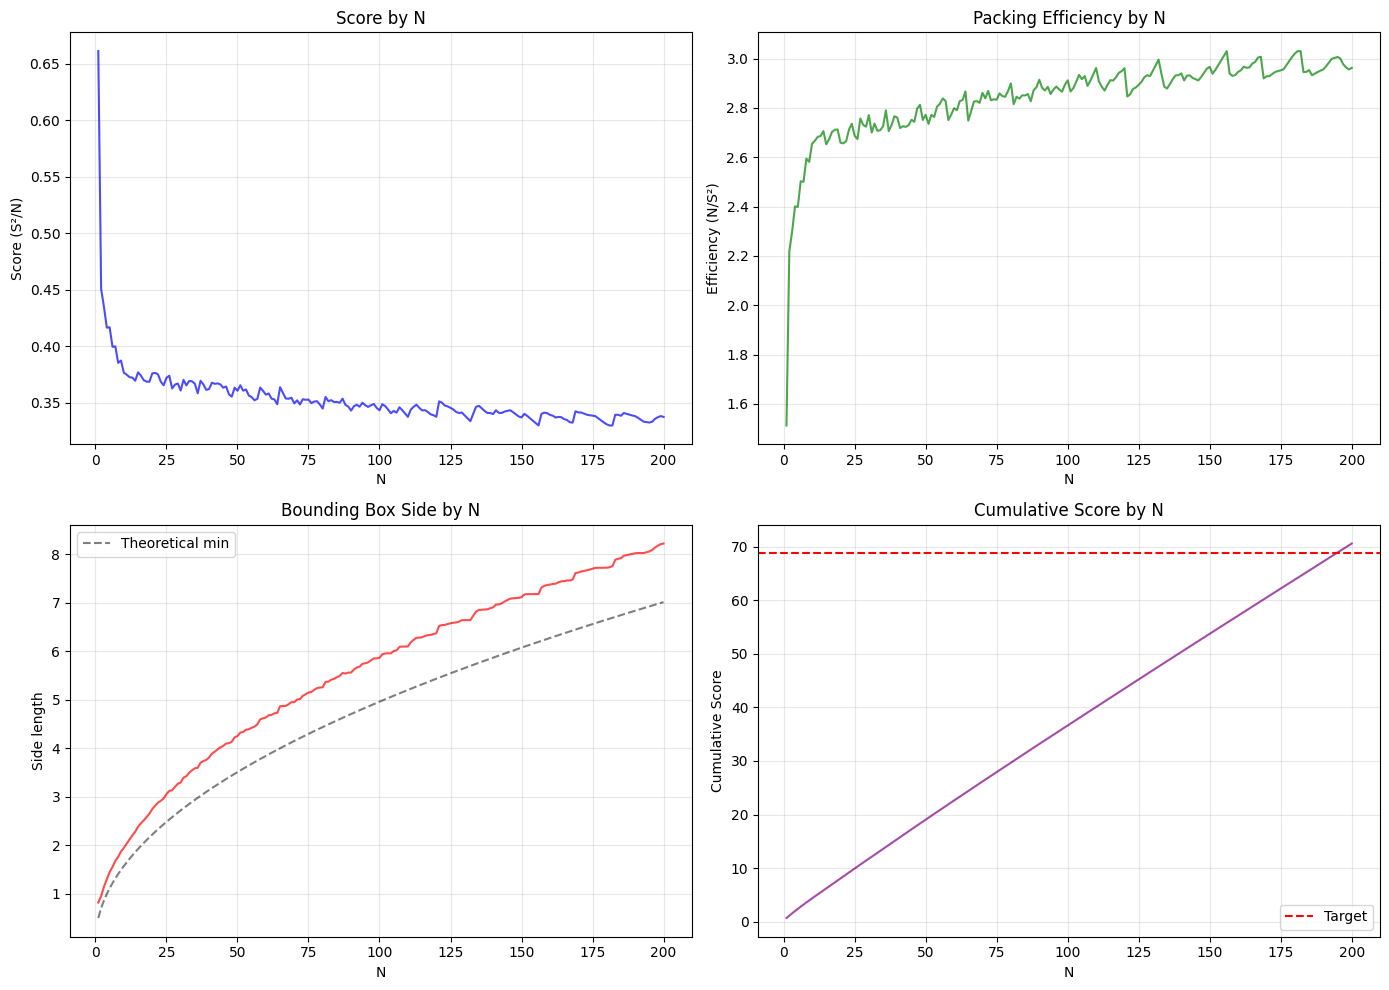


Score breakdown saved to score_breakdown.png


In [4]:
# Plot score by N
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score by N
ax1 = axes[0, 0]
ns = list(range(1, 201))
scores = [scores_by_n[n]['score'] for n in ns]
ax1.plot(ns, scores, 'b-', alpha=0.7)
ax1.set_xlabel('N')
ax1.set_ylabel('Score (S²/N)')
ax1.set_title('Score by N')
ax1.grid(True, alpha=0.3)

# Efficiency by N
ax2 = axes[0, 1]
efficiencies = [scores_by_n[n]['efficiency'] for n in ns]
ax2.plot(ns, efficiencies, 'g-', alpha=0.7)
ax2.set_xlabel('N')
ax2.set_ylabel('Efficiency (N/S²)')
ax2.set_title('Packing Efficiency by N')
ax2.grid(True, alpha=0.3)

# Side length by N
ax3 = axes[1, 0]
sides = [scores_by_n[n]['side'] for n in ns]
ax3.plot(ns, sides, 'r-', alpha=0.7)
ax3.plot(ns, [np.sqrt(n * tree_area) for n in ns], 'k--', alpha=0.5, label='Theoretical min')
ax3.set_xlabel('N')
ax3.set_ylabel('Side length')
ax3.set_title('Bounding Box Side by N')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Cumulative score
ax4 = axes[1, 1]
cum_scores = np.cumsum(scores)
ax4.plot(ns, cum_scores, 'purple', alpha=0.7)
ax4.axhline(y=68.919154, color='red', linestyle='--', label='Target')
ax4.set_xlabel('N')
ax4.set_ylabel('Cumulative Score')
ax4.set_title('Cumulative Score by N')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/code/exploration/score_breakdown.png', dpi=150)
plt.show()

print(f"\nScore breakdown saved to score_breakdown.png")

In [5]:
# Analyze where the gap comes from
# If we could improve each N by the same percentage, what % would we need?

current_total = total_score
target = 68.919154
gap = current_total - target
gap_pct = gap / current_total * 100

print(f"Current total: {current_total:.6f}")
print(f"Target: {target:.6f}")
print(f"Gap: {gap:.6f} ({gap_pct:.2f}%)")

# If we improved each N by X%, total would be current * (1 - X/100)
# We need current * (1 - X/100) = target
# So X = (1 - target/current) * 100
required_improvement_pct = (1 - target/current_total) * 100
print(f"\nRequired improvement: {required_improvement_pct:.2f}% across all N")

# Which N values have the most room for improvement?
# Compare to theoretical minimum
print("\nN values with worst efficiency (most room for improvement):")
worst_efficiency = sorted(scores_by_n.items(), key=lambda x: x[1]['efficiency'])[:20]
for n, data in worst_efficiency:
    theoretical_min = tree_area
    actual = data['score']
    room = (actual - theoretical_min) / actual * 100
    print(f"  N={n}: efficiency={data['efficiency']:.4f}, score={actual:.4f}, room={room:.1f}%")

Current total: 70.627896
Target: 68.919154
Gap: 1.708742 (2.42%)

Required improvement: 2.42% across all N

N values with worst efficiency (most room for improvement):
  N=1: efficiency=1.5123, score=0.6612, room=62.9%
  N=2: efficiency=2.2184, score=0.4508, room=45.5%
  N=3: efficiency=2.3002, score=0.4347, room=43.5%
  N=5: efficiency=2.3989, score=0.4168, room=41.1%
  N=4: efficiency=2.4007, score=0.4165, room=41.0%
  N=7: efficiency=2.5006, score=0.3999, room=38.6%
  N=6: efficiency=2.5024, score=0.3996, room=38.5%
  N=9: efficiency=2.5812, score=0.3874, room=36.6%
  N=8: efficiency=2.5947, score=0.3854, room=36.3%
  N=15: efficiency=2.6527, score=0.3770, room=34.8%
  N=10: efficiency=2.6551, score=0.3766, room=34.8%
  N=21: efficiency=2.6564, score=0.3765, room=34.8%
  N=20: efficiency=2.6592, score=0.3761, room=34.7%
  N=22: efficiency=2.6648, score=0.3753, room=34.5%
  N=11: efficiency=2.6672, score=0.3749, room=34.5%
  N=16: efficiency=2.6729, score=0.3741, room=34.3%
  N=26: e

In [6]:
# Check if there are specific N values where we're far from optimal
# Compare our efficiency to the best efficiency we've achieved

best_eff = max(s['efficiency'] for s in scores_by_n.values())
print(f"Best efficiency achieved: {best_eff:.6f}")

print("\nN values where efficiency is far below best:")
for n in range(1, 201):
    eff = scores_by_n[n]['efficiency']
    if eff < best_eff * 0.9:  # More than 10% below best
        gap_to_best = (best_eff - eff) / best_eff * 100
        potential_improvement = scores_by_n[n]['score'] - n / best_eff
        print(f"  N={n}: efficiency={eff:.4f} ({gap_to_best:.1f}% below best), potential improvement={potential_improvement:.4f}")

Best efficiency achieved: 3.030811

N values where efficiency is far below best:
  N=1: efficiency=1.5123 (50.1% below best), potential improvement=0.3313
  N=2: efficiency=2.2184 (26.8% below best), potential improvement=-0.2091
  N=3: efficiency=2.3002 (24.1% below best), potential improvement=-0.5551
  N=4: efficiency=2.4007 (20.8% below best), potential improvement=-0.9032
  N=5: efficiency=2.3989 (20.8% below best), potential improvement=-1.2329
  N=6: efficiency=2.5024 (17.4% below best), potential improvement=-1.5801
  N=7: efficiency=2.5006 (17.5% below best), potential improvement=-1.9097
  N=8: efficiency=2.5947 (14.4% below best), potential improvement=-2.2541
  N=9: efficiency=2.5812 (14.8% below best), potential improvement=-2.5821
  N=10: efficiency=2.6551 (12.4% below best), potential improvement=-2.9228
  N=11: efficiency=2.6672 (12.0% below best), potential improvement=-3.2545
  N=12: efficiency=2.6830 (11.5% below best), potential improvement=-3.5866
  N=13: efficienc

In [7]:
# Summary of findings
print("="*60)
print("SUMMARY OF FINDINGS")
print("="*60)

print(f"\n1. CURRENT STATE:")
print(f"   - Total score: {total_score:.6f}")
print(f"   - Target: 68.919154")
print(f"   - Gap: {gap:.6f} ({gap_pct:.2f}%)")

print(f"\n2. EFFICIENCY ANALYSIS:")
print(f"   - Best efficiency: {best_eff:.6f} trees/unit area")
print(f"   - Tree area: {tree_area:.6f}")
print(f"   - Theoretical max efficiency: {1/tree_area:.6f} (if trees packed perfectly)")

print(f"\n3. SCORE BREAKDOWN:")
print(f"   - N=1-50 contributes: {sum(scores_by_n[n]['score'] for n in range(1, 51)):.4f}")
print(f"   - N=51-100 contributes: {sum(scores_by_n[n]['score'] for n in range(51, 101)):.4f}")
print(f"   - N=101-150 contributes: {sum(scores_by_n[n]['score'] for n in range(101, 151)):.4f}")
print(f"   - N=151-200 contributes: {sum(scores_by_n[n]['score'] for n in range(151, 201)):.4f}")

print(f"\n4. KEY INSIGHT:")
print(f"   - To reach target, we need {required_improvement_pct:.2f}% improvement")
print(f"   - This is {gap:.4f} points across 200 N values")
print(f"   - Average improvement needed per N: {gap/200:.6f}")

print(f"\n5. NEXT STEPS:")
print(f"   - SA-based optimization has hit a wall (0.000085 improvement in 11 experiments)")
print(f"   - Need fundamentally different approach")
print(f"   - Consider: exact solvers for small N, different tessellation patterns, asymmetric layouts")

SUMMARY OF FINDINGS

1. CURRENT STATE:
   - Total score: 70.627896
   - Target: 68.919154
   - Gap: 1.708742 (2.42%)

2. EFFICIENCY ANALYSIS:
   - Best efficiency: 3.030811 trees/unit area
   - Tree area: 0.245625
   - Theoretical max efficiency: 4.071247 (if trees packed perfectly)

3. SCORE BREAKDOWN:
   - N=1-50 contributes: 19.0341
   - N=51-100 contributes: 17.6144
   - N=101-150 contributes: 17.1364
   - N=151-200 contributes: 16.8430

4. KEY INSIGHT:
   - To reach target, we need 2.42% improvement
   - This is 1.7087 points across 200 N values
   - Average improvement needed per N: 0.008544

5. NEXT STEPS:
   - SA-based optimization has hit a wall (0.000085 improvement in 11 experiments)
   - Need fundamentally different approach
   - Consider: exact solvers for small N, different tessellation patterns, asymmetric layouts
